# Characterization of Bayesian posterior density

The objective of this example is to demonstrate how transport maps can be used to represent posterior distribution of Bayesian inference problems.

## Imports
First, import MParT and other packages used in this notebook. Note that it is possible to specify the number of threads used by MParT by setting the `KOKKOS_NUM_THREADS` environment variable **before** importing MParT.

In [1]:
import numpy as np
import scipy 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

import os
os.environ['KOKKOS_NUM_THREADS'] = '8'

import mpart as mt
print('Kokkos is using', mt.Concurrency(), 'threads')
plt.rcParams['figure.dpi'] = 110

Kokkos::OpenMP::initialize WARNING: You are likely oversubscribing your CPU cores.
  process threads available :   4,  requested thread :   8


Kokkos::OpenMP::initialize WARNING: You are likely oversubscribing your CPU cores.
                                    Detected: 4 cores per node.
                                    Detected: 1 MPI_ranks per node.
                                    Requested: 8 threads per process.


Kokkos is using 8 threads


## Problem formulation

### Bayesian inference

 A way construct a transport map is from an unnormalized density. One situation where we know the probality density function up to a normalization constant is when modeling inverse problems with Bayesian inference.

For an inverse problem, the objective is to characterize the value of some parameters $\boldsymbol{\theta}$ of a given system, knowing some the value of some noisy observations $\mathbf{y}$.

With Bayesian inference, the characterization of parameters $\boldsymbol{\theta}$ is done via a *posterior* density $\pi(\boldsymbol{\theta}|\mathbf{y})$. This density characterizes the distribution of the parameters knowing the value of the observations.

Using Bayes' rule, the posterior can decomposed into the product of two probability densities:

1.   The prior density $\pi(\boldsymbol{\theta})$ which is used to enforce any *a priori* knowledge about the parameters.
2.   The likelihood function $\pi(\mathbf{y}|\boldsymbol{\theta})$. This quantity can be seen as a function of $\boldsymbol{\theta}$ and gives the likelihood that the considered system produced the observation $\mathbf{y}$ for a fixed value of $\boldsymbol{\theta}$. When the model that describes the system is known in closed form, the likelihood function is also knwon in closed form.

Hence, the posterior density reads:

$$
\pi(\boldsymbol{\theta}|\mathbf{y}) = \frac{1}{c} \pi(\mathbf{y}|\boldsymbol{\theta}) \pi(\boldsymbol{\theta})
$$

where $c = \int \pi(\mathbf{y}|\boldsymbol{\theta}) \pi(\boldsymbol{\theta}) d\theta$ is an normalizing constant that ensures that the product of the two quantities is a proper density.  Typically, the integral in this definition cannot be evaluated and $c$ is assumed to be unknown.

The objective of this examples is, from the knowledge of $\pi(\mathbf{y}|\boldsymbol{\theta})\pi(\boldsymbol{\theta})$ build a transport map that transports samples from the reference $\eta$ to samples from posterior $\pi(\boldsymbol{\theta}|\mathbf{y})$.

### Application with the Biochemical Oxygen Demand (BOD) model from [[Sullivan et al., 2010]](https://or.water.usgs.gov/proj/keno_reach/download/chemgeo_bod_final.pdf)

#### Definition

To illustrate the process describe above, we consider the BOD inverse problem described in [[Marzouk et al., 2016]](https://arxiv.org/pdf/1602.05023.pdf).   The goal is to estimate $2$ coefficients in a time-dependent model of oxygen demand, which is used as an indication of biological activity in a water sample.

The time dependent forward model is defined as

$$
\mathcal{B}(t) = A(1-\exp(-Bt))+\mathcal{E},
$$

where

$$
\begin{aligned}
\mathcal{E} & \sim \mathcal{N}(0,1e-3)\\
A & = \left[0.4 + 0.4\left(1 + \text{erf}\left(\frac{\theta_1}{\sqrt{2}} \right)\right) \right]\\
B & = \left[0.01 + 0.15\left(1 + \text{erf}\left(\frac{\theta_2}{\sqrt{2}} \right)\right) \right]
\end{aligned}
$$

The objective is to characterize the posterior density of parameters $\boldsymbol{\theta}=(\theta_1,\theta_2)$ knowing observation of the system at time $t=\left\{1,2,3,4,5 \right\}$ i.e. $\mathbf{y} = (y_1,y_2,y_3,y_4,y_5) = (\mathcal{B}(1),\mathcal{B}(2),\mathcal{B}(3),\mathcal{B}(4),\mathcal{B}(5))$.

Definition of the forward model and gradient with respect to $\mathbf{\theta}$:

In [2]:
def forward_model(p1,p2,t):
  A = 0.4+0.4*(1+scipy.special.erf(p1/np.sqrt(2)))
  B = 0.01+0.15*(1+scipy.special.erf(p2/np.sqrt(2)))
  out = A*(1-np.exp(-B*t))
  return out

def grad_x_forward_model(p1,p2,t):
  A = 0.4+0.4*(1+scipy.special.erf(p1/np.sqrt(2)))
  B = 0.01+0.15*(1+scipy.special.erf(p2/np.sqrt(2)))
  dAdx1 = 0.31954*np.exp(-0.5*p1**2)
  dBdx2 = 0.119683*np.exp(-0.5*p2**2)
  dOutdx1 = dAdx1*(1-np.exp(-B*t))
  dOutdx2 = t*A*dBdx2*np.exp(-t*B)
  return np.vstack((dOutdx1,dOutdx2))

One simulation of the forward model:

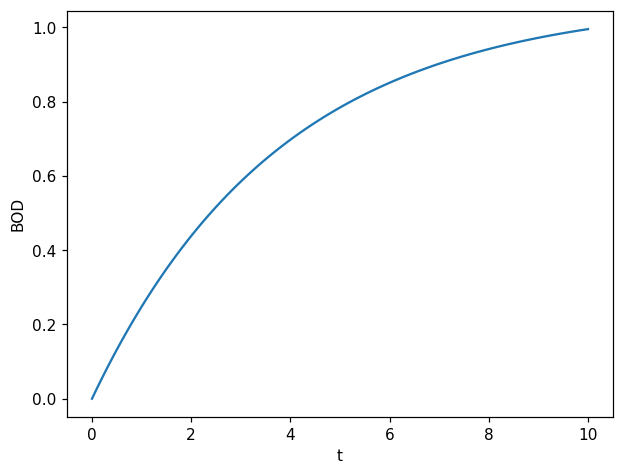

In [3]:
t = np.linspace(0,10, 100)
fig, ax = plt.subplots(1,1)
ax.plot(t, forward_model(1, 1, t));
ax.set_xlabel("t")
ax.set_ylabel("BOD");

For this problem, as noise $\mathcal{E}$ is Gaussian and additive, the likelihood function $\pi(\mathbf{y}|\boldsymbol{\theta})$, can be decomposed for each time step as:
$$\pi(\mathbf{y}|\boldsymbol{\theta}) = \prod_{t=1}^{5} \pi(y_t|\boldsymbol{\theta}), $$
where 
$$\pi(\mathbf{y}_t|\boldsymbol{\theta})=\frac{1}{\sqrt{0.002.\pi}}\exp \left(-\frac{1}{0.002} \left(y_t - \mathcal{B}(t)\right)^2 \right), t \in \{1,...,5\}.$$

Likelihood function and its gradient with respect to parameters:

In [4]:
def log_likelihood(std_noise,t,yobs,p1,p2):
  y = forward_model(p1,p2,t)
  log_lkl = -np.log(np.sqrt(2*np.pi)*std_noise)-0.5*((y-yobs)/std_noise)**2
  return log_lkl

def grad_x_log_likelihood(std_noise,t,yobs,p1,p2):
  y = forward_model(p1,p2,t)
  dydx = grad_x_forward_model(p1,p2,t)
  grad_x_lkl = (-1/std_noise**2)*(y - yobs)*dydx
  return grad_x_lkl

We can then define the unnormalized posterior and its gradient with respect to parameters:

In [5]:
def log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,p1,p2):
  log_prior1 = -np.log(np.sqrt(2*np.pi)*std_prior1)-0.5*(p1/std_prior1)**2
  log_prior2 = -np.log(np.sqrt(2*np.pi)*std_prior2)-0.5*(p2/std_prior2)**2
  log_posterior = log_prior1+log_prior2
  for k,t in enumerate(list_t):
    log_posterior += log_likelihood(std_noise,t,list_yobs[k],p1,p2)
  return log_posterior

def grad_x_log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,p1,p2):
  grad_x1_prior = -(1/std_prior1**2)*(p1)
  grad_x2_prior = -(1/std_prior2**2)*(p2)
  grad_x_prior = np.vstack((grad_x1_prior,grad_x2_prior))
  grad_x_log_posterior = grad_x_prior 
  for k,t in enumerate(list_t):
    grad_x_log_posterior += grad_x_log_likelihood(std_noise,t,list_yobs[k],p1,p2)
  return grad_x_log_posterior

#### Observations

We consider the following realization of observation $\mathbf{y}$:

In [6]:
list_t = np.array([1,2,3,4,5])
list_yobs = np.array([0.18,0.32,0.42,0.49,0.54])

std_noise = np.sqrt(1e-3)
std_prior1 = 1
std_prior2 = 1

#### Visualization of the **unnormalized** posterior density

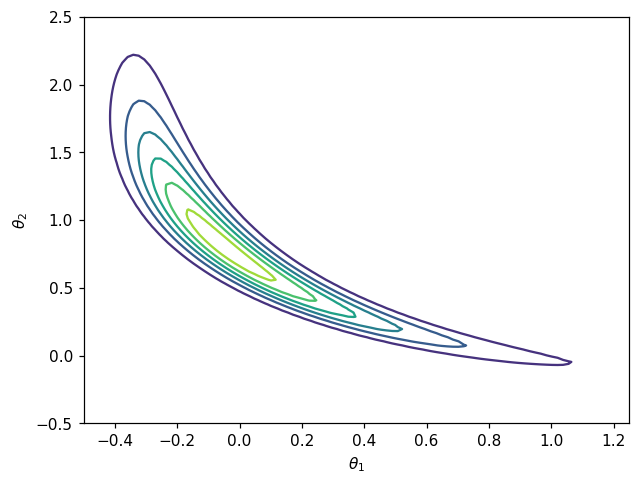

In [7]:
Ngrid = 100
x = np.linspace(-0.5, 1.25, Ngrid)
y = np.linspace(-0.5, 2.5, Ngrid)
X, Y = np.meshgrid(x, y)

Z = log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,X.flatten(),Y.flatten())
Z = np.exp(Z.reshape(Ngrid,Ngrid))


fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
plt.show()

Target density for the map from density is non-Gaussian which mean that a non linear map will be required to achieve good approximation.

## Map computation

After the definition of the log-posterior and gradient, the construction of the desired map $T$ to characterize the posterior density result in a "classic" map from unnomarlized computation.

### Definition of the objective function:

Knowing the closed form of unnormalized posterior $\bar{\pi}(\boldsymbol{\theta} |\mathbf{y})= \pi(\mathbf{y}|\boldsymbol{\theta})\pi(\boldsymbol{\theta})$, the objective is to find a map-induced density $\tilde{\pi}_{\mathbf{w}}(\mathbf{x})$ that is a good approximation to the posterior $\pi(\boldsymbol{\theta} |\mathbf{y})$.

In order to characterize this posterior density, one method is to build a transport map.

For the map from unnormalized density estimation, the objective function on parameter $\mathbf{w}$ reads:

$$
J(\mathbf{w}) = - \frac{1}{N}\sum_{i=1}^N \left( \log\pi\left(T(\mathbf{z}^i;\mathbf{w})\right) + \log  \text{det }\nabla_\mathbf{z} T(\mathbf{z}^i;\mathbf{w})\right), \,\,\, \mathbf{z}^i \sim \mathcal{N}(\mathbf{0},\mathbf{I}_d),
$$

where $T$ is the transport map pushing forward the standard normal $\mathcal{N}(\mathbf{0},\mathbf{I}_d)$ to the target density $\pi(\mathbf{x})$, which will be the the posterior density.  The gradient of this objective function reads:

$$
\nabla_\mathbf{w} J(\mathbf{w}) = - \frac{1}{N}\sum_{i=1}^N \left( \nabla_\mathbf{w} T(\mathbf{z}^i;\mathbf{w}).\nabla_\mathbf{x}\log\pi\left(T(\mathbf{z}^i;\mathbf{w})\right) + \nabla_{\mathbf{w}}\log  \text{det }\nabla_\mathbf{z} T(\mathbf{z}^i;\mathbf{w})\right), \,\,\, \mathbf{z}^i \sim \mathcal{N}(\mathbf{0},\mathbf{I}_d).
$$

In [8]:
def grad_x_log_target(x):
  out = grad_x_log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,x[0,:],x[1,:])
  return out

def log_target(x):
  out = log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,x[0,:],x[1,:])
  return out

def obj(coeffs, tri_map,x):
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)
    map_of_x = tri_map.Evaluate(x)
    rho_of_map_of_x = log_target(map_of_x)
    log_det = tri_map.LogDeterminant(x)
    return -np.sum(rho_of_map_of_x + log_det)/num_points

def grad_obj(coeffs, tri_map, x):
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)
    map_of_x = tri_map.Evaluate(x)
    sensi = grad_x_log_target(map_of_x)
    grad_rho_of_map_of_x = tri_map.CoeffGrad(x, sensi) 
    grad_log_det = tri_map.LogDeterminantCoeffGrad(x)
    return -np.sum(grad_rho_of_map_of_x + grad_log_det, 1)/num_points

In [9]:
#Draw reference samples to define objective
N=10000
z = np.random.randn(2,N)

#### Map parametrization

We use the MParT function `CreateTriangular` to directly create a transport map object of dimension with given total order parameterization.



In [10]:
# Create transport map
opts = mt.MapOptions()
total_order = 3
tri_map = mt.CreateTriangular(2,2,total_order,opts)

#### Optimization

In [11]:
options={'gtol': 1e-2, 'disp': True}
res = scipy.optimize.minimize(obj, tri_map.CoeffMap(), args=(tri_map, z), jac=grad_obj, method='BFGS', options=options)

Optimization terminated successfully.
         Current function value: -6.235995
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26


## Accuracy checks

### Comparing density contours 

Comparison between contours of the posterior $\pi(\boldsymbol{\theta}|\mathbf{y})$ and conoturs of pushforward density $T_\sharp \eta$.

In [12]:
# Pushforward distribution
def push_forward_pdf(tri_map,ref,x):
  xinv = tri_map.Inverse(x,x)
  log_det_grad_x_inverse = - tri_map.LogDeterminant(xinv)
  log_pdf = ref.logpdf(xinv.T)+log_det_grad_x_inverse
  return np.exp(log_pdf)

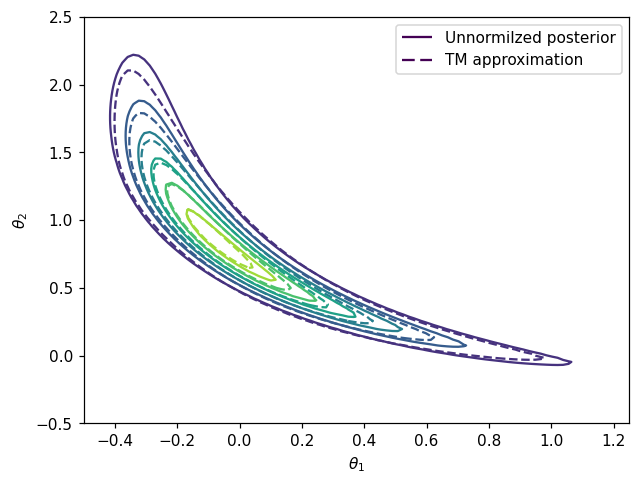

In [13]:
# Reference distribution
ref = multivariate_normal(np.zeros(2),np.eye(2))

xx_eval = np.vstack((X.flatten(),Y.flatten()))
Z2 = push_forward_pdf(tri_map,ref,xx_eval)
Z2 = Z2.reshape(Ngrid,Ngrid)

fig, ax = plt.subplots()
CS1 = ax.contour(X, Y, Z)
CS2 = ax.contour(X, Y, Z2,linestyles='dashed')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
h1,_ = CS1.legend_elements()
h2,_ = CS2.legend_elements()
ax.legend([h1[0], h2[0]], ['Unnormilzed posterior', 'TM approximation'])
plt.show()

### Variance diagnostic

A commonly used accuracy check when facing computation maps from density is the so-called variance diagnostic defined as:

$$ \epsilon_\sigma = \frac{1}{2} \mathbb{V}\text{ar}_\rho \left[ \log \frac{\rho}{T^\sharp \bar{\pi}} \right] $$

This diagnostic is asymptotically equivalent to the minimized KL divergence $D_{KL}(\eta || T^\sharp \pi)$ and should converge to zero when the computed map converge to the theoritical true map.

In [14]:
def variance_diagnostic(tri_map,ref,target_logpdf,x):
  ref_logpdf = ref.logpdf(x.T)
  y = tri_map.Evaluate(x)
  pullback_logpdf = target_logpdf(y) + tri_map.LogDeterminant(x)
  diff = ref_logpdf - pullback_logpdf
  expect = np.mean(diff)
  var = 0.5*np.mean((diff-expect)**2)
  return var

In [15]:
# Reference distribution
ref_distribution = multivariate_normal(np.zeros(2),np.eye(2));

test_z = np.random.randn(2,10000)
# Compute variance diagnostic
var_diag = variance_diagnostic(tri_map,ref,log_target,test_z)

# Print final coeffs and objective
print('==================')
print('Variance diagnostic: {:.2E}'.format(var_diag))
print('==================')

Variance diagnostic: 1.83E-02


### Drawing samples from approximate posterior

Once the transport map from reference to unnormalized posterior is estimated it can be used to sample from the posterior to characterize the Bayesian inference solution. 

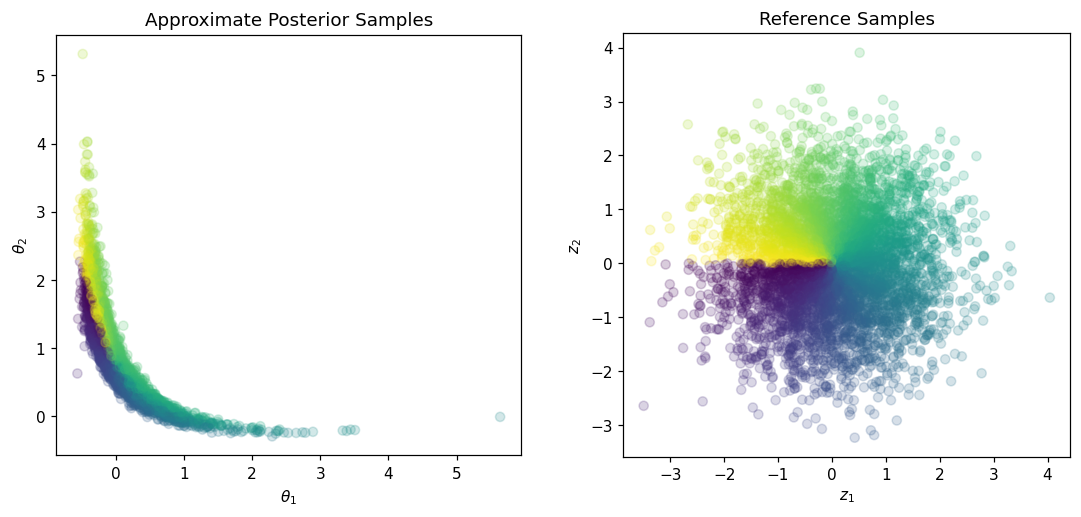

In [16]:
Znew = np.random.randn(2,5000)
colors = np.arctan2(Znew[1,:],Znew[0,:])

Xpost = tri_map.Evaluate(Znew)

fig,axs = plt.subplots(ncols=2,figsize=(12,5))
axs[0].scatter(Xpost[0,:],Xpost[1,:], c=colors, alpha=0.2)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlabel(r'$\theta_1$')
axs[0].set_ylabel(r'$\theta_2$')
axs[0].set_title('Approximate Posterior Samples')

axs[1].scatter(Znew[0,:],Znew[1,:], c=colors, alpha=0.2)
axs[1].set_aspect('equal', 'box')
axs[1].set_xlabel(r'$z_1$')
axs[1].set_ylabel(r'$z_2$')
axs[1].set_title('Reference Samples')


plt.show()

Samples can then be used to compute quantity of interest with respect to parameters $\boldsymbol{\theta}$. For example the sample mean:

In [17]:
X_mean = np.mean(Xpost,1)
print('Mean a posteriori: '+str(X_mean))

Mean a posteriori: [0.03870845 0.91108788]


Samples can also be used to study parameters marginas. Here are the one-dimensional marginals histograms:

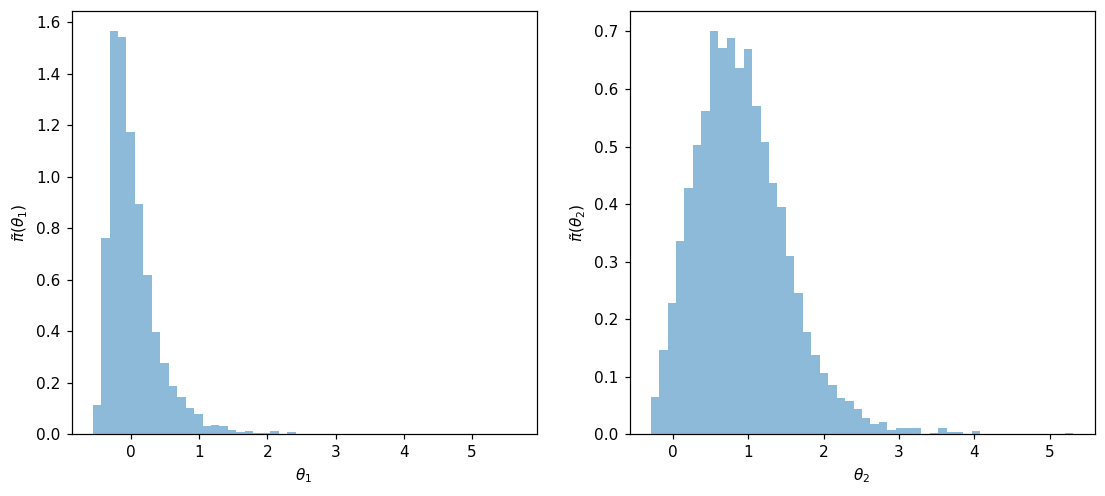

In [18]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].hist(Xpost[0,:], 50, alpha=0.5, density=True)
ax[0].set_xlabel(r'$\theta_1$')
ax[0].set_ylabel(r'$\tilde{\pi}(\theta_1)$')
ax[1].hist(Xpost[1,:], 50, alpha=0.5, density=True)
ax[1].set_xlabel(r'$\theta_2$')
ax[1].set_ylabel(r'$\tilde{\pi}(\theta_2)$')
plt.show()